# 计算一定输入电流、一定出口温度下不同碱液流量对应的AWE制氢功耗

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 设置字体为支持中文的字体，如SimHei（黑体）
matplotlib.rcParams['font.family'] = 'SimHei'
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

from Model.Static_Model.Static_Electrolyzer_Model_Hyzenis import AWE_Electrolyzer_Static

## 实例化电解槽

In [2]:
AWE_Electrolyzer = AWE_Electrolyzer_Static(Diameter_Electrode = 560 * 1E-3,
                                    Width_Cell = 5 * 1E-3,
                                    Num_Cells = 31,
                                    Lye_flow_min = 0.3,
                                    Lye_flow_max = 0.5,
                                    Static_Electrochemical_params_file_path = r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Electrochemical_params_Hyzenis.pth',
                                    Static_Thermal_params_file_path = r'D:\Devs\Single_Stack_MLJ\src\Model\Static_Model\Static_Thermal_params_Hyzenis.pth')

## 画出极化曲线

d:\Devs\Single_Stack_MLJ\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


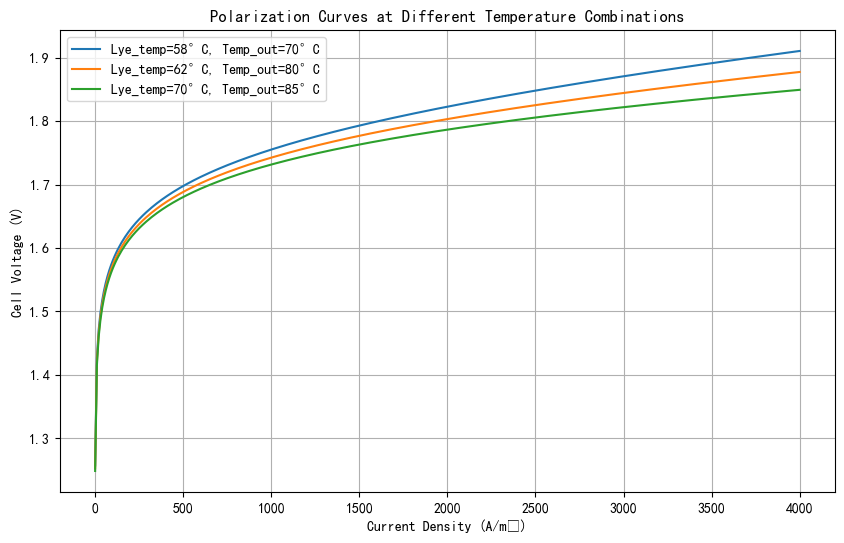

In [3]:
# 定义电流密度范围
current_densities = np.linspace(0, 4000, 400)

# 定义温度组合
temperature_combinations = [(58, 70), (62, 80), (70, 85)]

# 碱液流量和压力
Lye_flow = 0.45
Pressure = 1.6

# 初始化绘图
plt.figure(figsize=(10, 6))

# 遍历不同的温度组合
for Lye_temp, Temp_out in temperature_combinations:
    # 计算每个电流密度下的电池电压
    voltages = []
    for Current_density in current_densities:
        Vcell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp, Temp_out, Current_density, Lye_flow, Pressure)
        voltages.append(Vcell)

    # 绘制极化曲线
    plt.plot(current_densities, voltages, label=f'Lye_temp={Lye_temp}°C, Temp_out={Temp_out}°C')

# 设置图表标题和标签
plt.title('Polarization Curves at Different Temperature Combinations')
plt.xlabel('Current Density (A/m²)')
plt.ylabel('Cell Voltage (V)')
plt.legend()
plt.grid(True)

# 显示图表
plt.show()

## 画出3500电密下不同出口温度、不同流量下入口温度map图

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_3500 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_3500 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_3500 = np.array([])  # 入口温度记录
V_cell_array_3500 = np.array([])  # 电压记录
Power_H_array_3500 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_3500, lye_flow_array_3500)      # 创建二维网格

for lye_flow in lye_flow_array_3500:
    for temp_out in temp_out_array_3500:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 3500,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_3500 = np.append(lye_temp_array_3500, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 3500,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_3500 = np.append(V_cell_array_3500, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=3500,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_3500 = np.append(Power_H_array_3500, Power_H)


lye_temp_array_3500 = lye_temp_array_3500.reshape(len(lye_flow_array_3500), len(temp_out_array_3500))
V_cell_array_3500 = V_cell_array_3500.reshape(len(lye_flow_array_3500), len(temp_out_array_3500))
Power_H_array_3500 = Power_H_array_3500.reshape(len(lye_flow_array_3500), len(temp_out_array_3500))

In [17]:
V_cell_array_3500_reshape = V_cell_array_3500.T
Power_H_array_3500_reshape = Power_H_array_3500.T

# 不同出口温度下最小电耗
min_Power_H_array_3500_indices = np.argmin(Power_H_array_3500_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_3500 = lye_flow_array_3500[min_Power_H_array_3500_indices]

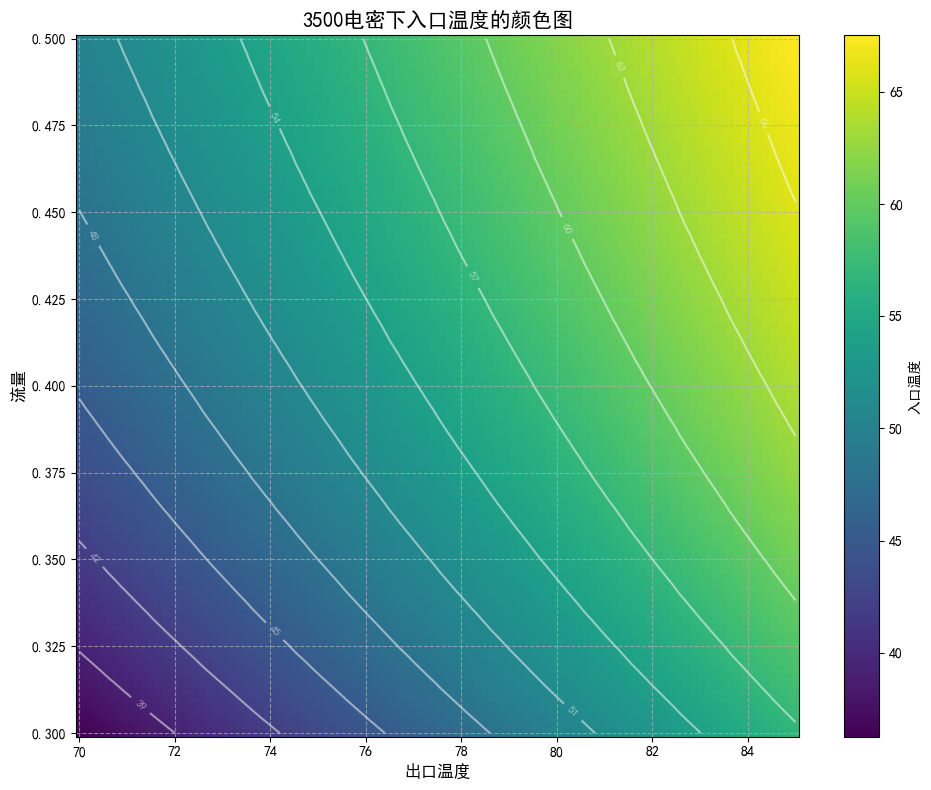

In [49]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_3500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('3500电密下入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_3500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

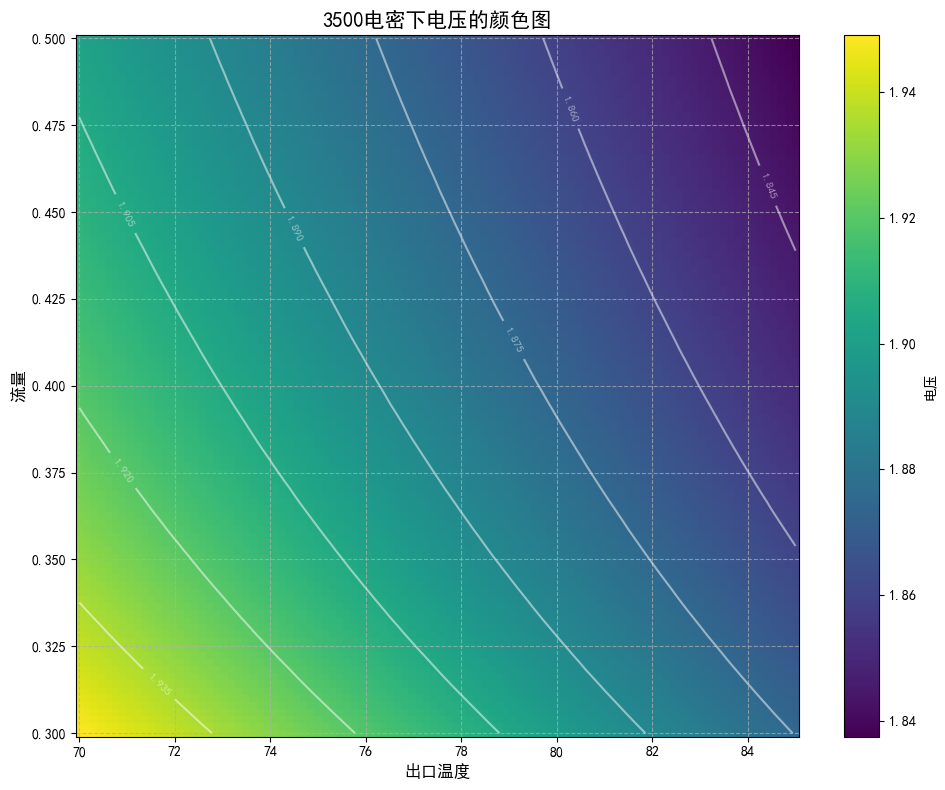

In [48]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_3500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('3500电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_3500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

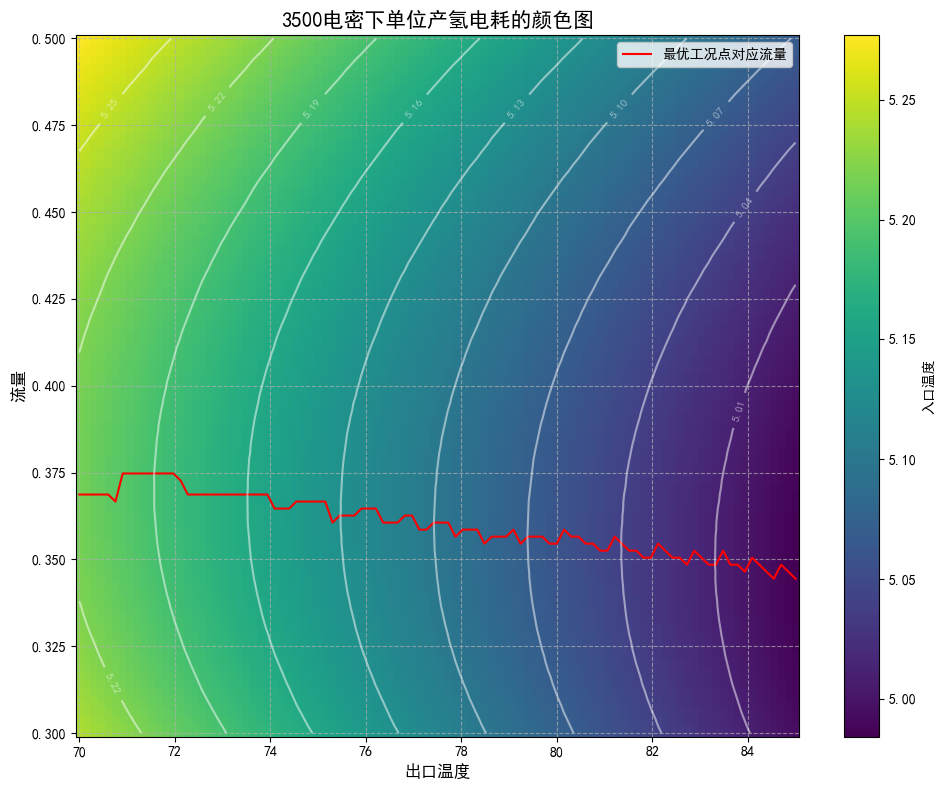

In [47]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_3500, min_Power_H_lye_flow_array_3500, c='r', label='最优工况点对应流量')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_3500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('3500电密下单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_3500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出3000电密下不同出口温度、不同流量下入口温度map图

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_3000 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_3000 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_3000 = np.array([])  # 入口温度记录
V_cell_array_3000 = np.array([])  # 电压记录
Power_H_array_3000 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_3000, lye_flow_array_3000)      # 创建二维网格

for lye_flow in lye_flow_array_3000:
    for temp_out in temp_out_array_3000:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 3000,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_3000 = np.append(lye_temp_array_3000, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 3000,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_3000 = np.append(V_cell_array_3000, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=3000,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_3000 = np.append(Power_H_array_3000, Power_H)


lye_temp_array_3000 = lye_temp_array_3000.reshape(len(lye_flow_array_3000), len(temp_out_array_3000))
V_cell_array_3000 = V_cell_array_3000.reshape(len(lye_flow_array_3000), len(temp_out_array_3000))
Power_H_array_3000 = Power_H_array_3000.reshape(len(lye_flow_array_3000), len(temp_out_array_3000))

In [19]:
V_cell_array_3000_reshape = V_cell_array_3000.T
Power_H_array_3000_reshape = Power_H_array_3000.T

# 不同出口温度下最小电耗
min_Power_H_array_3000_indices = np.argmin(Power_H_array_3000_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_3000 = lye_flow_array_3000[min_Power_H_array_3000_indices]

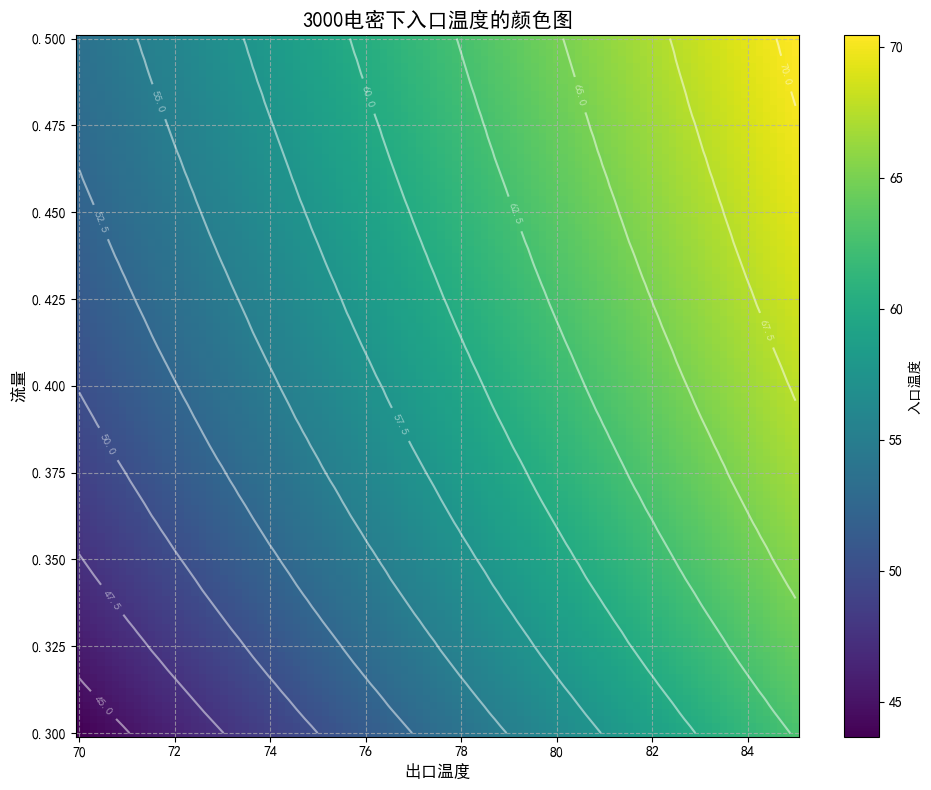

In [46]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('3000电密下入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

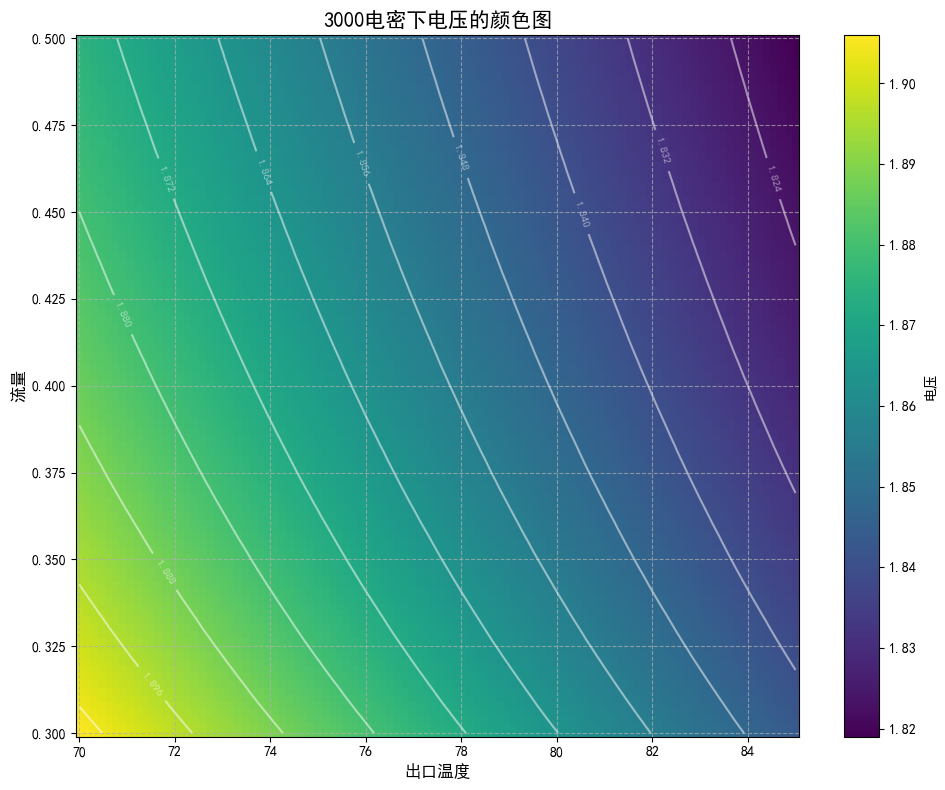

In [45]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('3000电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

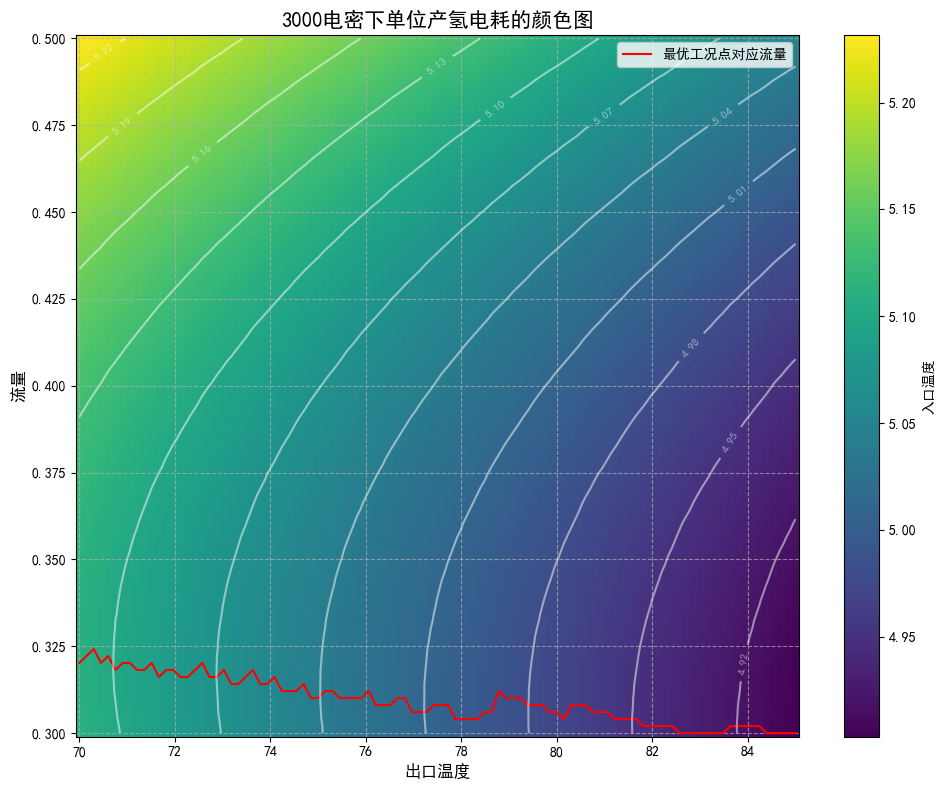

In [44]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_3000, min_Power_H_lye_flow_array_3000, c='r', label='最优工况点对应流量')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_3000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('3000电密下单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_3000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出2500电密下不同出口温度、不同流量下入口温度map图

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_2500 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_2500 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_2500 = np.array([])  # 入口温度记录
V_cell_array_2500 = np.array([])  # 电压记录
Power_H_array_2500 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_2500, lye_flow_array_2500)      # 创建二维网格

for lye_flow in lye_flow_array_2500:
    for temp_out in temp_out_array_2500:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 2500,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_2500 = np.append(lye_temp_array_2500, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 2500,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_2500 = np.append(V_cell_array_2500, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=2500,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_2500 = np.append(Power_H_array_2500, Power_H)


lye_temp_array_2500 = lye_temp_array_2500.reshape(len(lye_flow_array_2500), len(temp_out_array_2500))
V_cell_array_2500 = V_cell_array_2500.reshape(len(lye_flow_array_2500), len(temp_out_array_2500))
Power_H_array_2500 = Power_H_array_2500.reshape(len(lye_flow_array_2500), len(temp_out_array_2500))

KeyboardInterrupt: 

In [24]:
V_cell_array_2500_reshape = V_cell_array_2500.T
Power_H_array_2500_reshape = Power_H_array_2500.T

# 不同出口温度下最小电耗
min_Power_H_array_2500_indices = np.argmin(Power_H_array_2500_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_2500 = lye_flow_array_2500[min_Power_H_array_2500_indices]

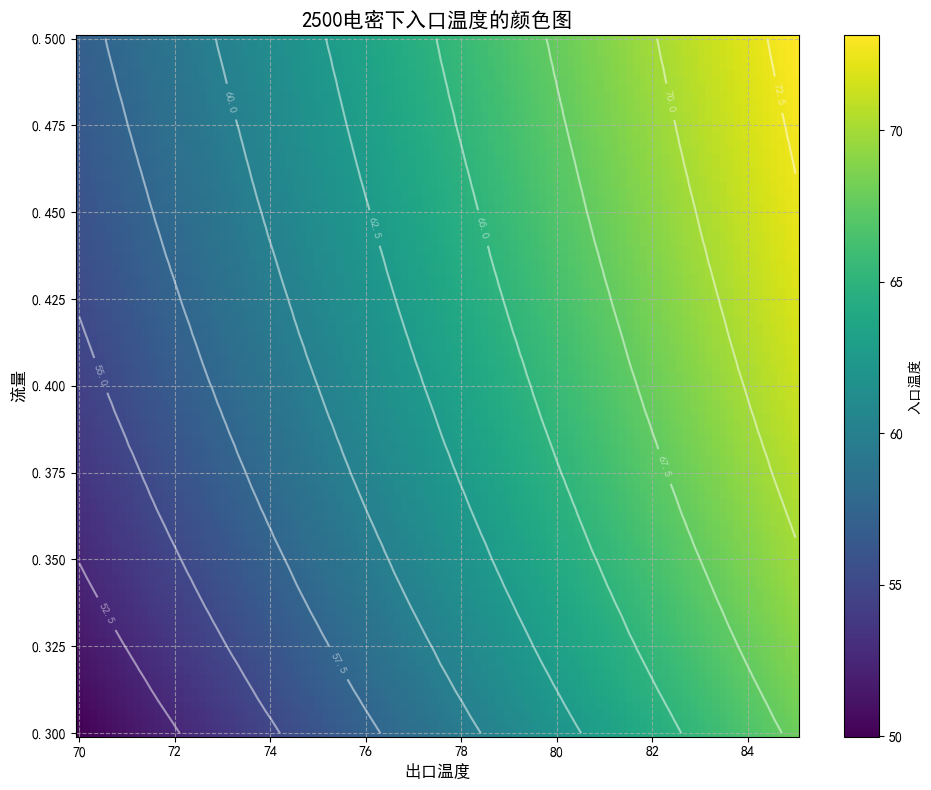

In [43]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2500电密下入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

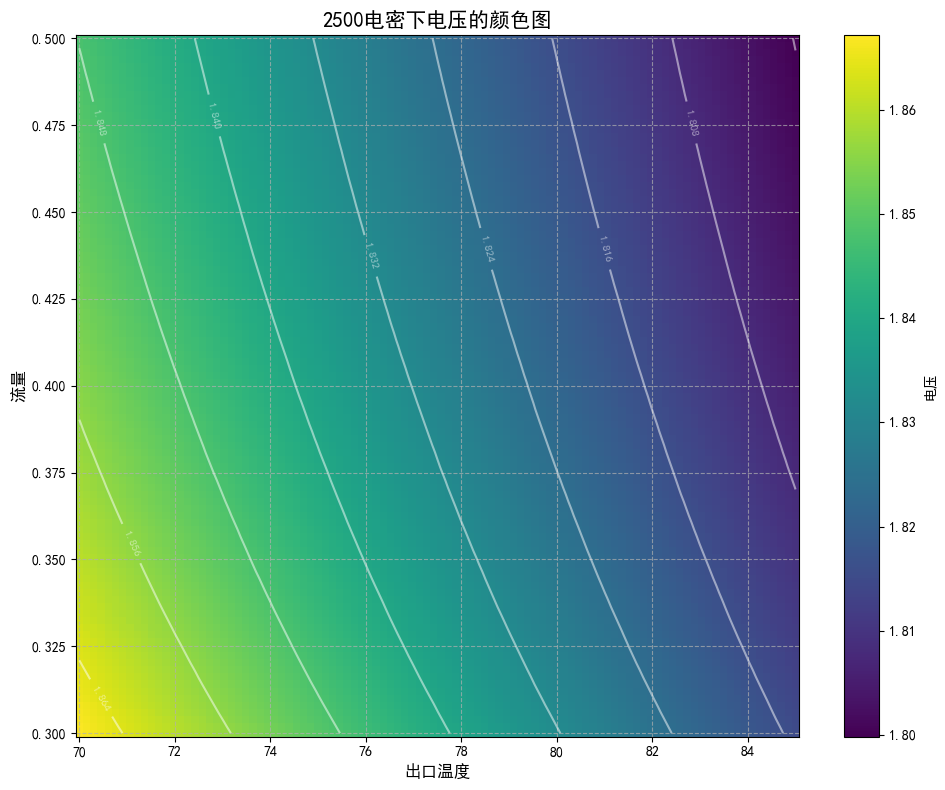

In [42]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('2500电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

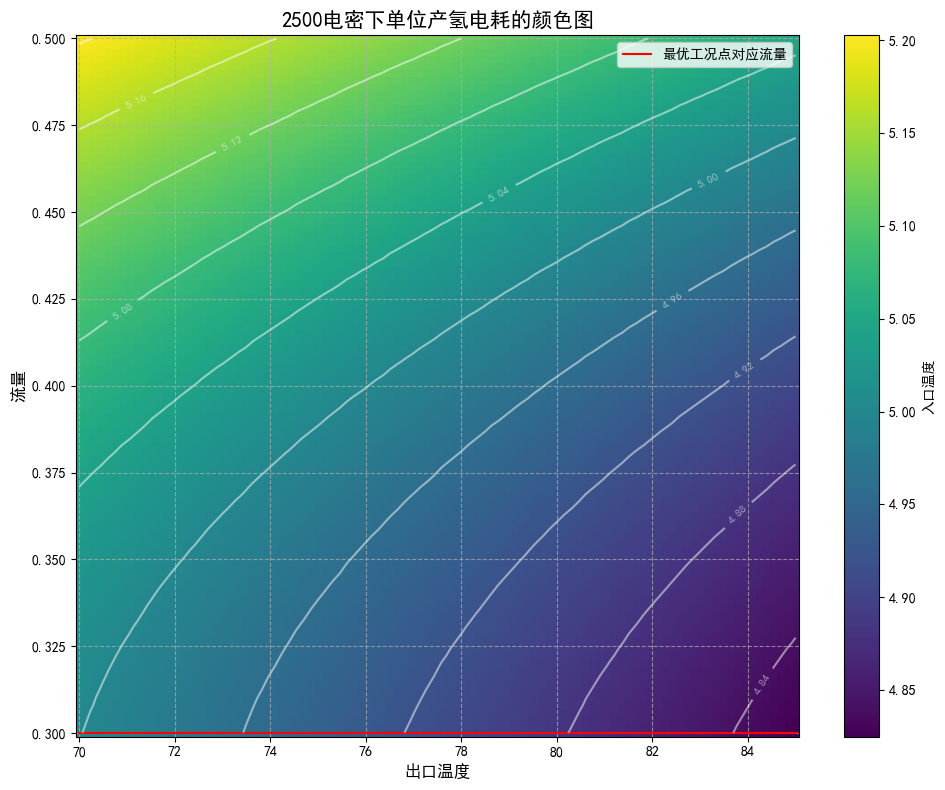

In [41]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_2500, min_Power_H_lye_flow_array_2500, c='r', label='最优工况点对应流量')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_2500, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2500电密下单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_2500, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出2000电密下不同出口温度、不同流量下入口温度map图

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 创建网格数据
temp_out_array_2000 = np.linspace(70, 85, 100)  # 出口温度范围从60到85，间隔0.05度
lye_flow_array_2000 = np.linspace(0.3, 0.5, 100)  # 流量范围从0.3到0.5，间隔0.001m3/h
lye_temp_array_2000 = np.array([])  # 入口温度记录
V_cell_array_2000 = np.array([])  # 电压记录
Power_H_array_2000 = np.array([])  # 电耗记录
X, Y = np.meshgrid(temp_out_array_2000, lye_flow_array_2000)      # 创建二维网格

for lye_flow in lye_flow_array_2000:
    for temp_out in temp_out_array_2000:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = 2000,
                                   Temp_out = temp_out,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        lye_temp_array_2000 = np.append(lye_temp_array_2000, lye_temp)
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = temp_out,
                                                   Current_density = 2000,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        V_cell_array_2000 = np.append(V_cell_array_2000, V_cell)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=2000,
                                                   Temp_out=temp_out,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        Power_H_array_2000 = np.append(Power_H_array_2000, Power_H)


lye_temp_array_2000 = lye_temp_array_2000.reshape(len(lye_flow_array_2000), len(temp_out_array_2000))
V_cell_array_2000 = V_cell_array_2000.reshape(len(lye_flow_array_2000), len(temp_out_array_2000))
Power_H_array_2000 = Power_H_array_2000.reshape(len(lye_flow_array_2000), len(temp_out_array_2000))

In [29]:
V_cell_array_2000_reshape = V_cell_array_2000.T
Power_H_array_2000_reshape = Power_H_array_2000.T

# 不同出口温度下最小电耗
min_Power_H_array_2000_indices = np.argmin(Power_H_array_2000_reshape, axis=1)
# 不同出口温度下最小电耗对应的流量
min_Power_H_lye_flow_array_2000 = lye_flow_array_2000[min_Power_H_array_2000_indices]

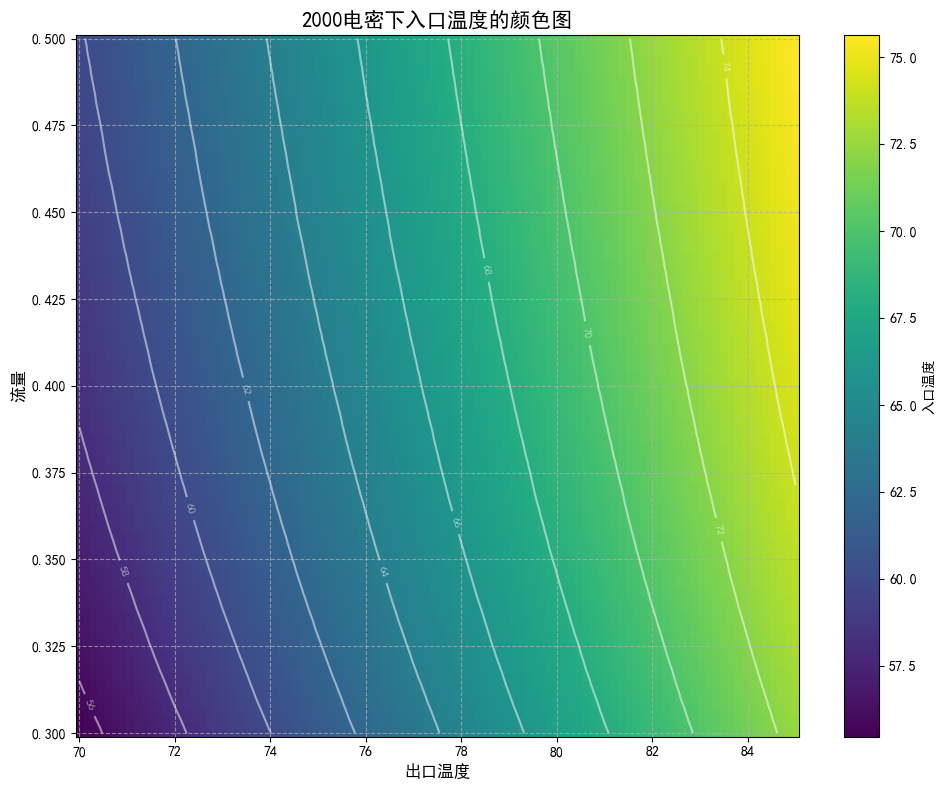

In [40]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, lye_temp_array_2000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2000电密下入口温度的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, lye_temp_array_2000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

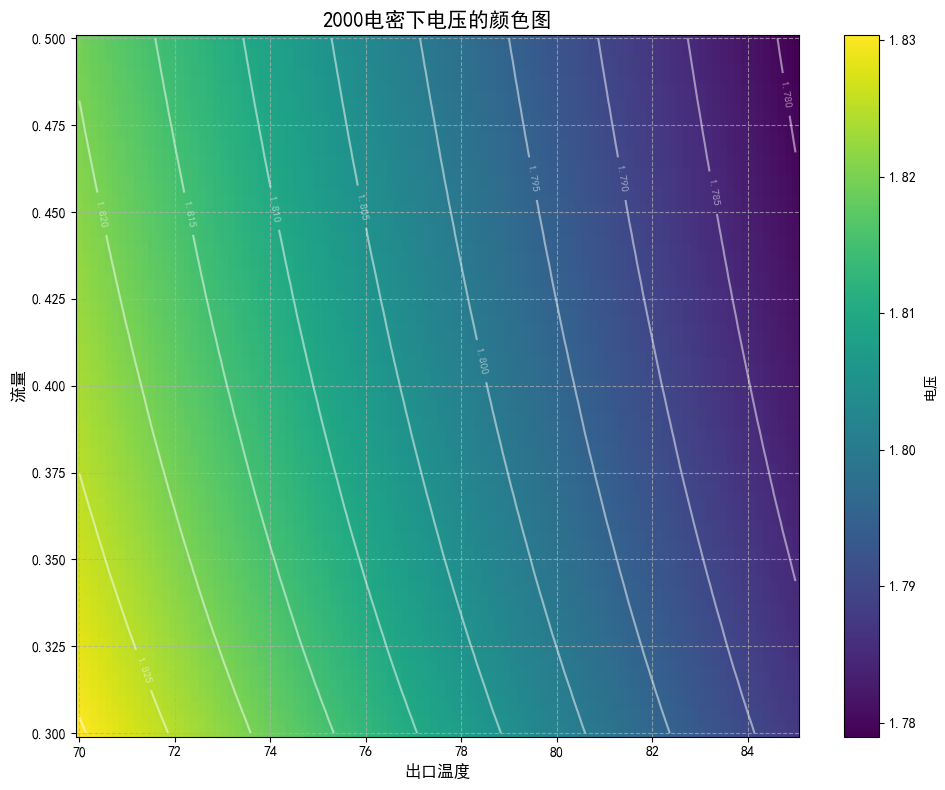

In [39]:
# 创建图形
plt.figure(figsize=(10, 8))

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, V_cell_array_2000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='电压')

# 设置标题和坐标轴标签
plt.title('2000电密下电压的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, V_cell_array_2000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

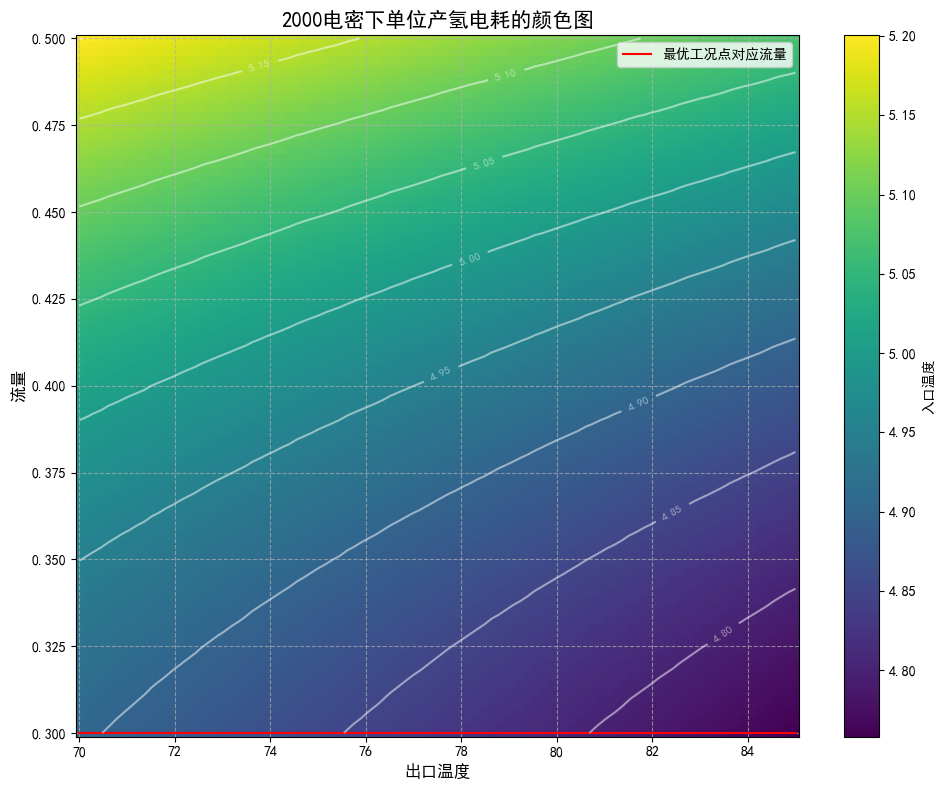

In [38]:
# 创建图形
plt.figure(figsize=(10, 8))

plt.plot(temp_out_array_2000, min_Power_H_lye_flow_array_2000, c='r', label='最优工况点对应流量')
plt.legend()

# 使用pcolormesh绘制z值的颜色图
plt.pcolormesh(X, Y, Power_H_array_2000, shading='auto', cmap='viridis')

# 添加颜色条
plt.colorbar(label='入口温度')

# 设置标题和坐标轴标签
plt.title('2000电密下单位产氢电耗的颜色图', fontsize=15)
plt.xlabel('出口温度', fontsize=12)
plt.ylabel('流量', fontsize=12)

# 添加等高线，便于查看z值的分布
contour = plt.contour(X, Y, Power_H_array_2000, 10, colors='white', alpha=0.5)
plt.clabel(contour, inline=True, fontsize=8)

# 显示网格线
plt.grid(True, linestyle='--', alpha=0.7)

# 显示图形
plt.tight_layout()
plt.show()

## 画出出口温度85度3500、3000、2500、2000电密下不同碱液流量对应的功耗变化（横坐标流量，纵坐标不同种类功耗）

In [5]:
current_density_array_sep = np.array([3500, 3000, 2500, 2000])
lye_flow_array_sep = np.arange(0.3, 0.51, 0.01)
power_lye_pump_list = [[], [], [], []]
power_cooling_list = [[], [], [], []]
power_electrolysis_list = [[], [], [], []]
power_H_list = [[], [], [], []]


for current_density in current_density_array_sep:
    index = np.where(current_density_array_sep == current_density)[0][0]
    for lye_flow in lye_flow_array_sep:

        power_lye_pump = AWE_Electrolyzer.Power_Lye_Pump_cal(Lye_flow=lye_flow)
        power_lye_pump_list[index].append(power_lye_pump)


        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = current_density,
                                   Temp_out = 85,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        power_cooling = AWE_Electrolyzer.Power_Cooling_cal(Lye_flow = lye_flow,
                                          Temp_out = 85,
                                          Lye_temp = lye_temp) * 0.3 # 冷却功率 W
        power_cooling_list[index].append(power_cooling)
        
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = 85,
                                                   Current_density = current_density,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        power_electrolysis = current_density * V_cell * AWE_Electrolyzer.Area_Electrode * AWE_Electrolyzer.Num_Cells
        power_electrolysis_list[index].append(power_electrolysis)

        power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=current_density,
                                                   Temp_out=85,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        power_H_list[index].append(power_H)

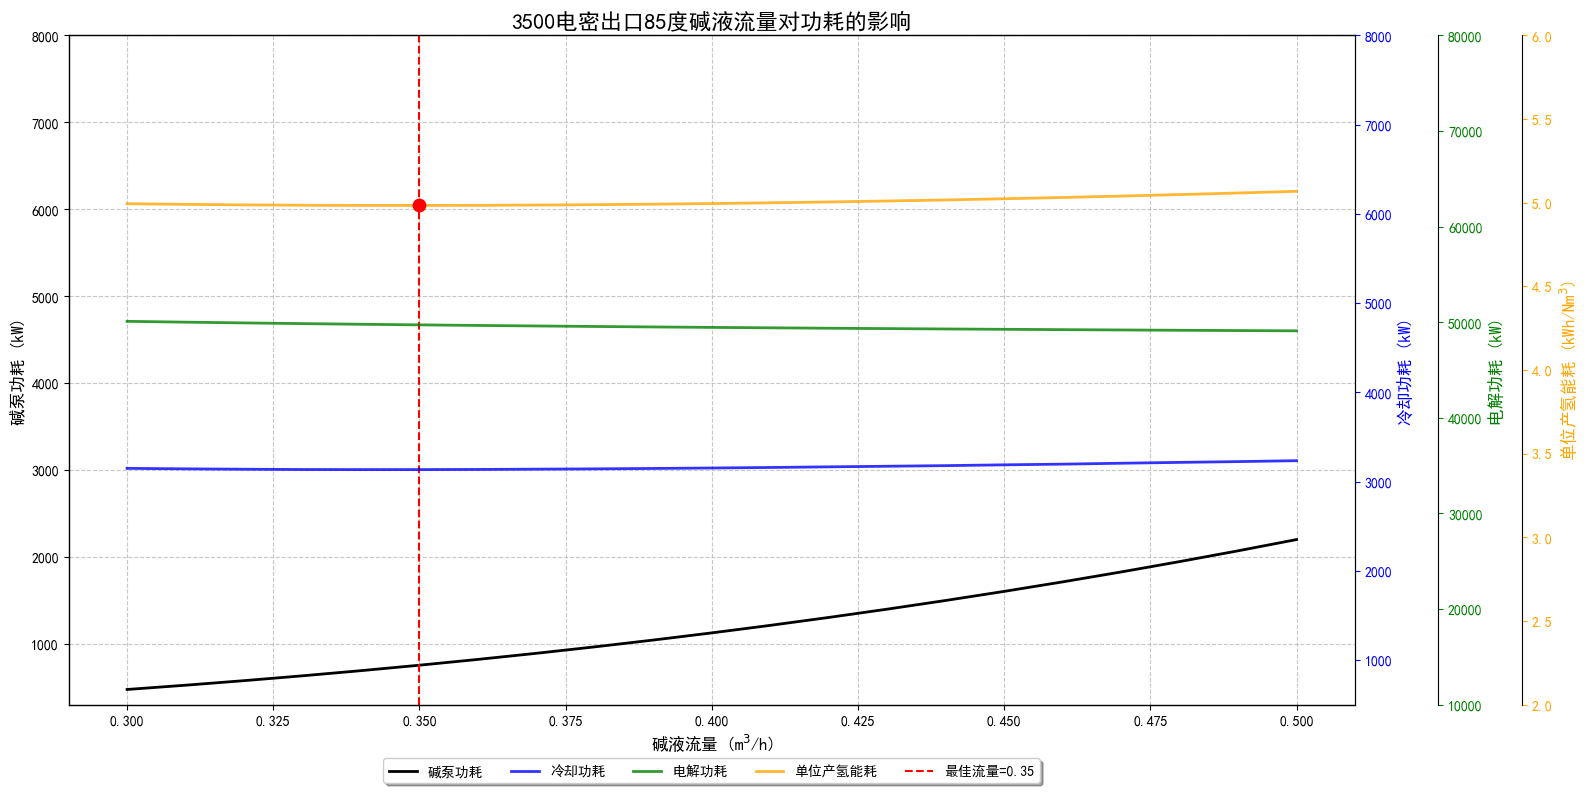

In [35]:
min_power_H_3500 = np.argmin(power_H_list[0])
lye_flow_at_min_power_H_3500 = lye_flow_array_sep[min_power_H_3500]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('3500电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[0], 
                 c='black', linewidth=2.0, label='碱泵功耗')
ax1.set_xlabel('碱液流量 (m$^3$/h)', fontsize=12)
ax1.set_ylabel('碱泵功耗 (kW)', color='black', fontsize=12)
ax1.set_ylim(300, 8000)
ax1.tick_params(axis='y', colors='black')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[0], 
                 alpha=0.8, c='blue', linewidth=2.0, label='冷却功耗')
ax2.set_ylabel('冷却功耗 (kW)', color='blue', fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(500, 8000)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[0], 
                 c='green', alpha=0.8, linewidth=2.0, label='电解功耗')
ax3.set_ylabel('电解功耗 (kW)', color='green', fontsize=12)
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', colors='green')
ax3.set_ylim(10000, 80000)

# 创建第四个y轴: 单位产氢能耗
ax4 = ax1.twinx()
line4, = ax4.plot(lye_flow_array_sep, power_H_list[0], 
                 c='orange', alpha=0.8, linewidth=2.0, label='单位产氢能耗')
ax4.set_ylabel('单位产氢能耗 (kWh/Nm$^3$)', color='orange', fontsize=12)
ax4.spines['right'].set_position(('outward', 120))
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim(2, 6)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_3500, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'最佳流量={lye_flow_at_min_power_H_3500:.2f}')

# 添加注释标记最低点
min_point = ax4.scatter([lye_flow_at_min_power_H_3500], 
                      [power_H_list[0][min_power_H_3500]], 
                      color='red', s=80, zorder=5)

# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, line4, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

## 3500电密下功耗堆积柱状图

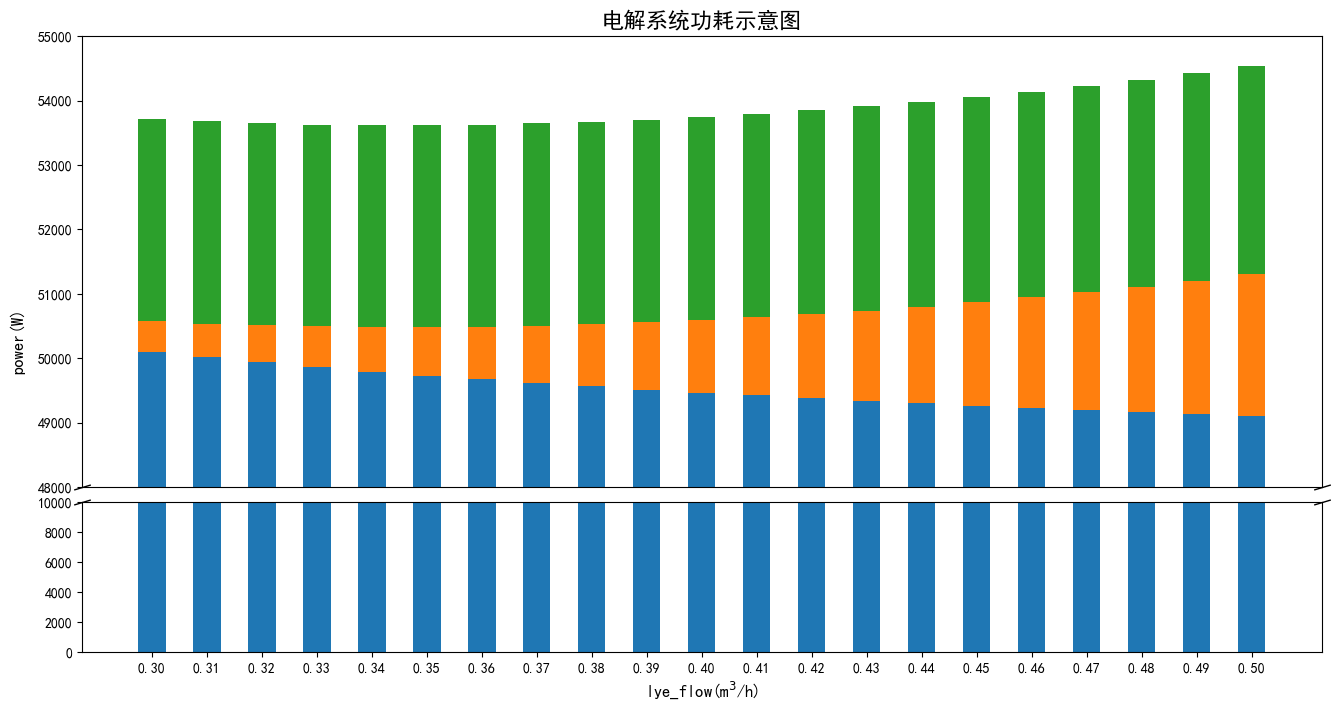

In [80]:
# 示例数据（包含一个特别大的值）
power_lye_pump_array = np.array(power_lye_pump_list[0])
power_cooling_array = np.array(power_cooling_list[0])
power_electrolysis_array = np.array(power_electrolysis_list[0])
power_H_array = np.array(power_H_list[0])

# 创建两个子图，共享x轴
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.05)  # 减少子图之间的间距

# 绘制上半部分（高值区域）
bottom1 = np.zeros(len(lye_flow_array_sep))
ax1.bar(lye_flow_array_sep, power_electrolysis_array, width=0.005, label='电解功耗', bottom=bottom1)
bottom1 += np.array(power_electrolysis_array)
ax1.bar(lye_flow_array_sep, power_lye_pump_array, width=0.005, label='碱泵功耗', bottom=bottom1)
bottom1 += np.array(power_lye_pump_array)
ax1.bar(lye_flow_array_sep, power_cooling_array, width=0.005, label='冷却功耗', bottom=bottom1)

# 绘制下半部分（低值区域）
bottom2 = np.zeros(len(lye_flow_array_sep))
ax2.bar(lye_flow_array_sep, power_electrolysis_array, width=0.005, label='电解功耗', bottom=bottom2)
bottom2 += np.array(power_electrolysis_array)
ax2.bar(lye_flow_array_sep, power_lye_pump_array, width=0.005, label='碱泵功耗', bottom=bottom2)
bottom2 += np.array(power_lye_pump_array)
ax2.bar(lye_flow_array_sep, power_cooling_array, width=0.005, label='冷却功耗', bottom=bottom2)

# 设置y轴范围
ax1.set_ylim(48000, 55000)  # 上半部分显示150-250
ax2.set_ylim(0, 10000)    # 下半部分显示0-100

# 添加断裂符号
d = .3  # 断裂符号的大小
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# 添加标题和标签
ax1.set_xticks(ticks=lye_flow_array_sep)
ax1.tick_params(axis='x', which='both', bottom=False)
ax1.set_title('电解系统功耗示意图', fontsize=16)
ax2.set_xlabel('lye_flow(m$^3$/h)', fontsize=12)
fig.text(0.085, 0.5, 'power(W)', va='center', ha='center', rotation='vertical', fontsize=12)

# 只在下方子图显示x轴刻度
plt.setp(ax1.get_xticklabels(), visible=False)

plt.show()

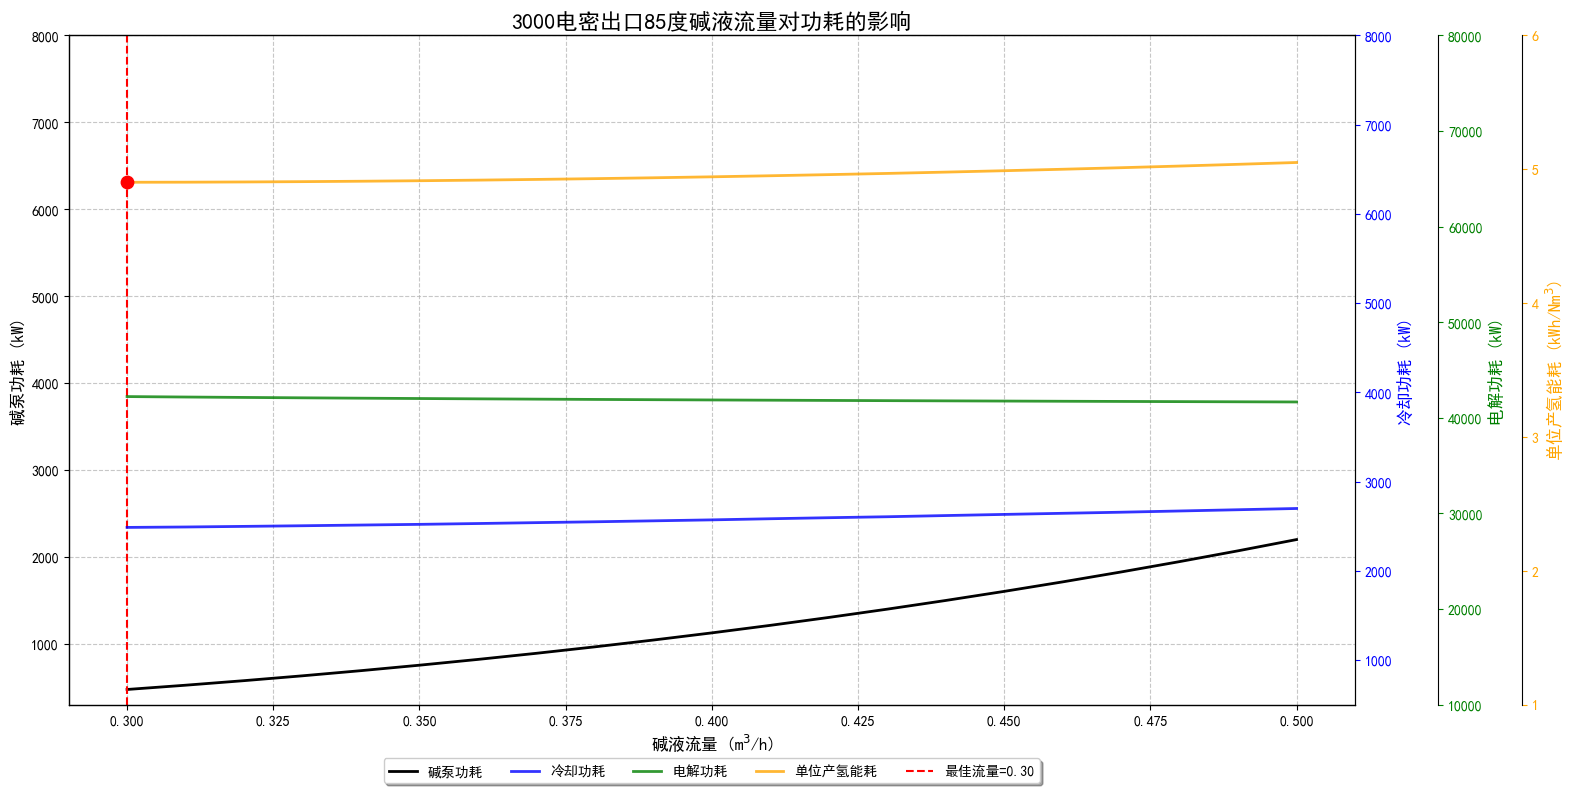

In [86]:
min_power_H_3000 = np.argmin(power_H_list[1])
lye_flow_at_min_power_H_3000 = lye_flow_array_sep[min_power_H_3000]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('3000电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[1], 
                 c='black', linewidth=2.0, label='碱泵功耗')
ax1.set_xlabel('碱液流量 (m$^3$/h)', fontsize=12)
ax1.set_ylabel('碱泵功耗 (kW)', color='black', fontsize=12)
ax1.set_ylim(300, 8000)
ax1.tick_params(axis='y', colors='black')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[1], 
                 alpha=0.8, c='blue', linewidth=2.0, label='冷却功耗')
ax2.set_ylabel('冷却功耗 (kW)', color='blue', fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(500, 8000)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[1], 
                 c='green', alpha=0.8, linewidth=2.0, label='电解功耗')
ax3.set_ylabel('电解功耗 (kW)', color='green', fontsize=12)
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', colors='green')
ax3.set_ylim(10000, 80000)

# 创建第四个y轴: 单位产氢能耗
ax4 = ax1.twinx()
line4, = ax4.plot(lye_flow_array_sep, power_H_list[1], 
                 c='orange', alpha=0.8, linewidth=2.0, label='单位产氢能耗')
ax4.set_ylabel('单位产氢能耗 (kWh/Nm$^3$)', color='orange', fontsize=12)
ax4.spines['right'].set_position(('outward', 120))
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim(1, 6)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_3000, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'最佳流量={lye_flow_at_min_power_H_3000:.2f}')

# 添加注释标记最低点
min_point = ax4.scatter([lye_flow_at_min_power_H_3000], 
                      [power_H_list[1][min_power_H_3000]], 
                      color='red', s=80, zorder=5)

# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, line4, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

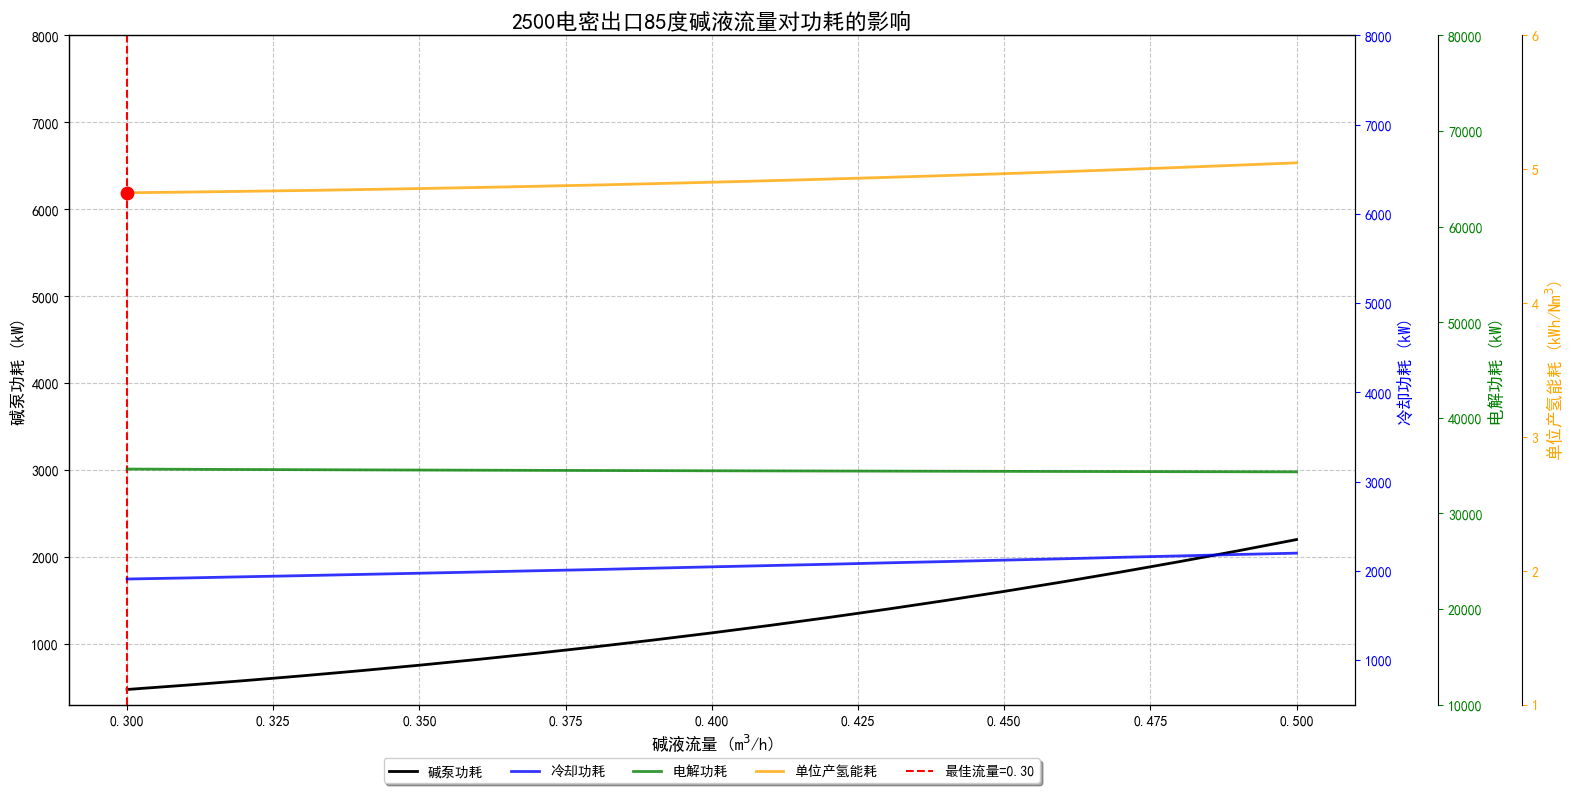

In [87]:
min_power_H_2500 = np.argmin(power_H_list[2])
lye_flow_at_min_power_H_2500 = lye_flow_array_sep[min_power_H_2500]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('2500电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[2], 
                 c='black', linewidth=2.0, label='碱泵功耗')
ax1.set_xlabel('碱液流量 (m$^3$/h)', fontsize=12)
ax1.set_ylabel('碱泵功耗 (kW)', color='black', fontsize=12)
ax1.set_ylim(300, 8000)
ax1.tick_params(axis='y', colors='black')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[2], 
                 alpha=0.8, c='blue', linewidth=2.0, label='冷却功耗')
ax2.set_ylabel('冷却功耗 (kW)', color='blue', fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(500, 8000)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[2], 
                 c='green', alpha=0.8, linewidth=2.0, label='电解功耗')
ax3.set_ylabel('电解功耗 (kW)', color='green', fontsize=12)
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', colors='green')
ax3.set_ylim(10000, 80000)

# 创建第四个y轴: 单位产氢能耗
ax4 = ax1.twinx()
line4, = ax4.plot(lye_flow_array_sep, power_H_list[2], 
                 c='orange', alpha=0.8, linewidth=2.0, label='单位产氢能耗')
ax4.set_ylabel('单位产氢能耗 (kWh/Nm$^3$)', color='orange', fontsize=12)
ax4.spines['right'].set_position(('outward', 120))
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim(1, 6)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_2500, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'最佳流量={lye_flow_at_min_power_H_2500:.2f}')

# 添加注释标记最低点
min_point = ax4.scatter([lye_flow_at_min_power_H_2500], 
                      [power_H_list[2][min_power_H_2500]], 
                      color='red', s=80, zorder=5)

# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, line4, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

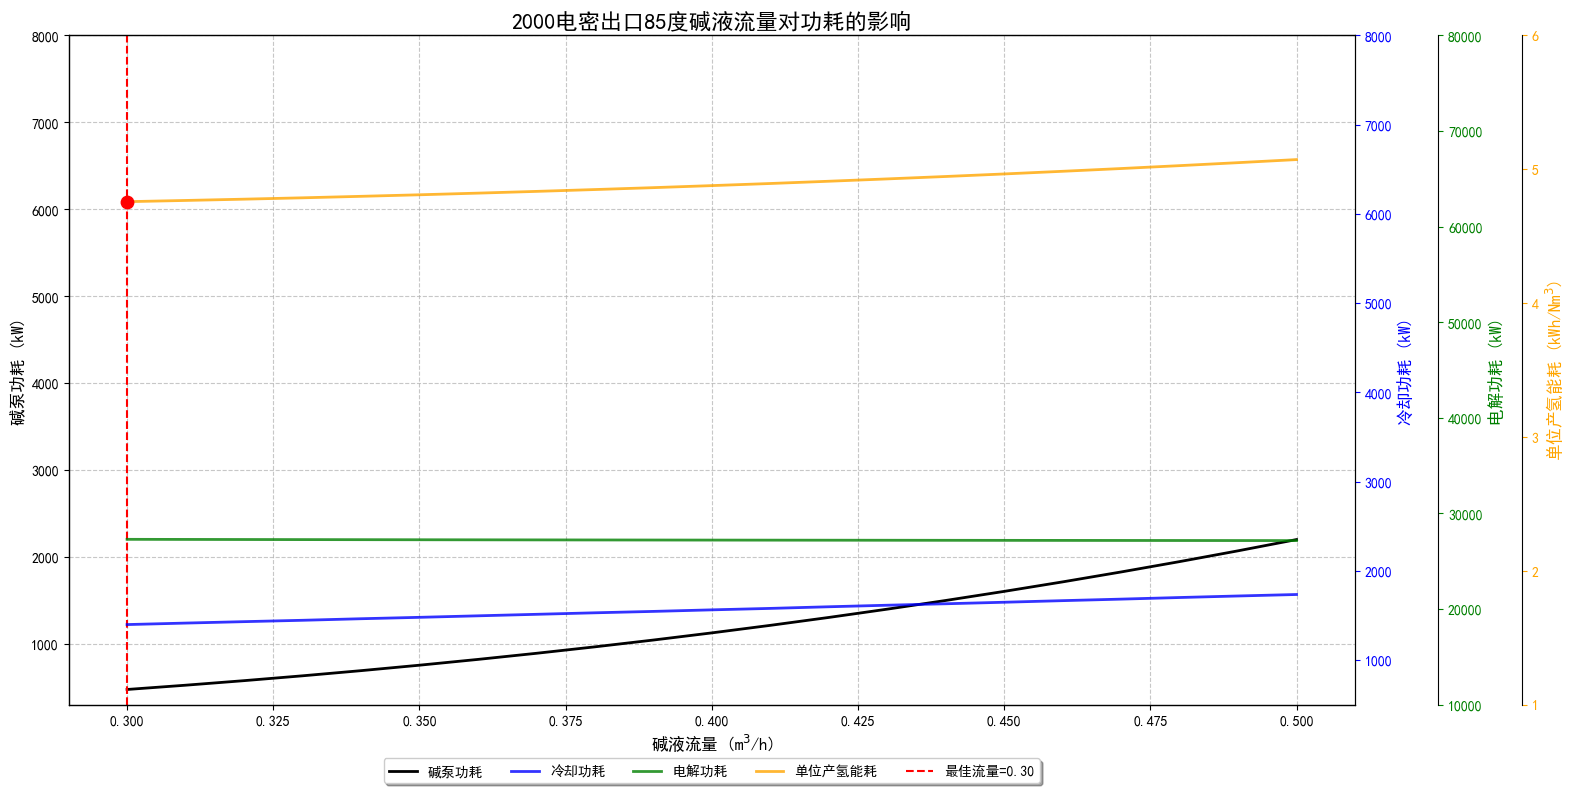

In [88]:
min_power_H_2000 = np.argmin(power_H_list[3])
lye_flow_at_min_power_H_2000 = lye_flow_array_sep[min_power_H_2000]

# 创建图表
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title('2000电密出口85度碱液流量对功耗的影响', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

# 绘制第一个因变量: 碱泵功耗
line1, = ax1.plot(lye_flow_array_sep, power_lye_pump_list[3], 
                 c='black', linewidth=2.0, label='碱泵功耗')
ax1.set_xlabel('碱液流量 (m$^3$/h)', fontsize=12)
ax1.set_ylabel('碱泵功耗 (kW)', color='black', fontsize=12)
ax1.set_ylim(300, 8000)
ax1.tick_params(axis='y', colors='black')

# 创建第二个y轴: 冷却功耗
ax2 = ax1.twinx()
line2, = ax2.plot(lye_flow_array_sep, power_cooling_list[3], 
                 alpha=0.8, c='blue', linewidth=2.0, label='冷却功耗')
ax2.set_ylabel('冷却功耗 (kW)', color='blue', fontsize=12)
ax2.tick_params(axis='y', colors='blue')
ax2.set_ylim(500, 8000)

# 创建第三个y轴: 电解功耗
ax3 = ax1.twinx()
line3, = ax3.plot(lye_flow_array_sep, power_electrolysis_list[3], 
                 c='green', alpha=0.8, linewidth=2.0, label='电解功耗')
ax3.set_ylabel('电解功耗 (kW)', color='green', fontsize=12)
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', colors='green')
ax3.set_ylim(10000, 80000)

# 创建第四个y轴: 单位产氢能耗
ax4 = ax1.twinx()
line4, = ax4.plot(lye_flow_array_sep, power_H_list[3], 
                 c='orange', alpha=0.8, linewidth=2.0, label='单位产氢能耗')
ax4.set_ylabel('单位产氢能耗 (kWh/Nm$^3$)', color='orange', fontsize=12)
ax4.spines['right'].set_position(('outward', 120))
ax4.tick_params(axis='y', colors='orange')
ax4.set_ylim(1, 6)

# 绘制单位产氢能耗最低时对应的碱液流量垂直线
min_line = ax1.axvline(x=lye_flow_at_min_power_H_2000, 
                     color='red', linestyle='--', linewidth=1.5,
                     label=f'最佳流量={lye_flow_at_min_power_H_2000:.2f}')

# 添加注释标记最低点
min_point = ax4.scatter([lye_flow_at_min_power_H_2000], 
                      [power_H_list[3][min_power_H_2000]], 
                      color='red', s=80, zorder=5)

# 优化图例显示 - 合并所有线条和标签
lines = [line1, line2, line3, line4, min_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
          ncol=5, fontsize=10, frameon=True, fancybox=True, shadow=True)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # 为右侧多个y轴腾出空间

# 显示图表
plt.show()

## 画出85度出口温度下不同电流密度对应的最优碱液流量（横坐标电流密度，纵坐标最优碱液流量）

In [12]:
current_density_array = np.arange(2000, 3500, 10)
best_lye_flow_array = np.array([])

# 计算不同电流密度对应的最优碱液流量
lye_flow_array = np.arange(0.3, 0.51, 0.01)
for current_density in current_density_array:
    best_lye_flow = None
    best_Power_h = float('inf')  
    for lye_flow in lye_flow_array:
        lye_temp  = AWE_Electrolyzer.Lye_temp_cal(Current_density = current_density,
                                   Temp_out = 85,
                                   Lye_flow = lye_flow,
                                   Temp_environment=20,
                                   Pressure = 1.6)  # 计算每个点的入口温度值
        V_cell = AWE_Electrolyzer.Electrolytic_voltage_cal(Lye_temp = lye_temp,
                                                   Temp_out = 85,
                                                   Current_density = current_density,
                                                   Lye_flow = lye_flow,
                                                   Pressure=1.6)
        Power_H = AWE_Electrolyzer.Power_per_H_cal(Lye_temp=lye_temp,
                                                   Current_density=current_density,
                                                   Temp_out=85,
                                                   Pressure=1.6,
                                                   Lye_flow=lye_flow)
        if Power_H < best_Power_h:
            best_Power_h = Power_H
            best_lye_flow = lye_flow
    best_lye_flow_array = np.append(best_lye_flow_array, best_lye_flow)

Text(0, 0.5, '碱液流量')

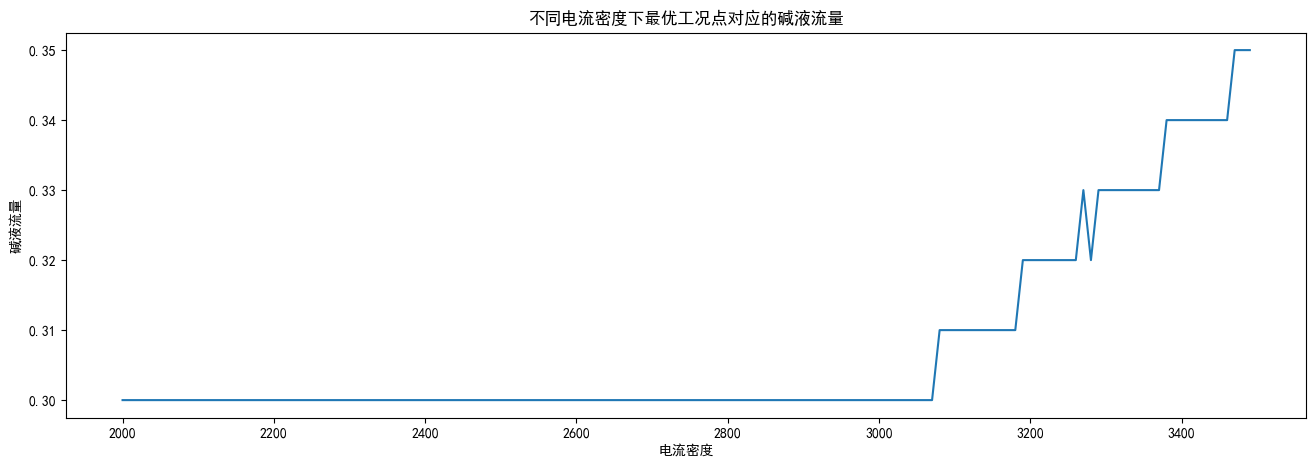

In [16]:
plt.figure(figsize=(16,5))

plt.plot(current_density_array, best_lye_flow_array)
plt.title('不同电流密度下最优工况点对应的碱液流量')
plt.xlabel('电流密度')
plt.ylabel('碱液流量')